In [1]:
# basic
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm  # to build a colormap

# geographic manipulation
import geopandas as gpd
from shapely.geometry import LineString

# EXTRA: hierarchical clustering (needed only for the final extra part)
from scipy.spatial import distance
from scipy.cluster import hierarchy
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

/home/sara/.local/lib/python3.8/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/tmp/ipykernel_15197/1707176954.py:8: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force to use Shapely 2.0 now, you can either uninstall PyGEOS or set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In the next release, GeoPandas will switch to using Shapely by default, even if PyGEOS is installed. If you only have PyGEOS installed to get speed-ups, this switch should be smooth. However, if you are using PyGEOS directly (

In [2]:
def number_in_scientific_notation(x, digits=1):
    """
    format a number in scientific notation (base 10)
    """
    form = '{' + ':.{}e'.format(digits) + '}'
    base, exponent = form.format(x).split('e')
    exponent = int(exponent) 
    return r'${}\cdot 10^{{{}}}$'.format( base, str(exponent) )

In [16]:
annual_flows = pd.read_excel(r"/home/sara/Documenti/GitHub/Climate-and-conflict/displacements/UNHCR-PRMN-Displacement-Dataset - Somalia.xlsx")
states_gdf = gpd.read_file(r"/home/sara/Documenti/GitHub/Climate-and-conflict/Datasets/som_adm_ocha_itos_20230308_shp/som_admbnda_adm2_ocha_20230308.shp")
df_d = pd.read_csv(r"/home/sara/Documenti/GitHub/Climate-and-conflict/csv/df_lags_2016_n4_disp_fd.csv")
distance = pd.read_csv(r"/home/sara/Documenti/GitHub/Climate-and-conflict/csv/dist_som.csv")

In [4]:
annual_flows1= annual_flows.groupby(["Current (Arrival) District","Previous (Departure) District"])["Number of Individuals"].sum().to_frame()
annual_flows1.drop(index=annual_flows1.index[0], axis=0, inplace=True)
annual_flows1

Number of Individuals
Current (Arrival) District Previous (Departure) District                       
Adan Yabaal                Adan Yabaal                                    15254
                           Cadale                                             6
Afgooye                    Adan Yabaal                                      246
                           Afgooye                                       126077
                           Afmadow                                           26
...                                                                         ...
Xudur                      Xudur                                         104129
Zeylac                     Baki                                             165
                           Borama                                           707
                           Lughaye                                          861
                           Zeylac                                          6581

[1283 rows x 1 columns]

In [5]:
D=annual_flows["Current (Arrival) District"].value_counts()
O=annual_flows["Previous (Departure) District"].value_counts()
set(D.keys()) == set(O.keys())

False

In [6]:
annual_flows1=annual_flows1.reset_index()
flow=annual_flows1.groupby("Previous (Departure) District")["Number of Individuals"].sum()
flow_destination=annual_flows1.groupby("Current (Arrival) District")["Number of Individuals"].sum()

In [7]:
OD_matrix = annual_flows1.pivot(index="Current (Arrival) District", columns="Previous (Departure) District", values='Number of Individuals')
OD_matrix = OD_matrix.fillna(0) 

In [8]:
#states_gdf = states_gdf.to_crs(epsg=4326)

# Calculate the centroid
states_gdf['centroid'] = states_gdf.geometry.centroid

/tmp/ipykernel_15197/1647790207.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  states_gdf['centroid'] = states_gdf.geometry.centroid


In [19]:
annual_flows
annual_flows.groupby(["Current (Arrival) Region","Previous (Departure) Region"])["Number of Individuals"].sum().to_frame()

Number of Individuals
Current (Arrival) Region Previous (Departure) Region                       
0                        Sool                                             3
Awdal                    Awdal                                        57602
                         Bakool                                          91
                         Banadir                                       1214
                         Bari                                            17
...                                                                     ...
Woqooyi Galbeed          Nugaal                                        1103
                         Sanaag                                        2422
                         Sool                                         14562
                         Togdheer                                     12304
                         Woqooyi Galbeed                              18888

[225 rows x 1 columns]

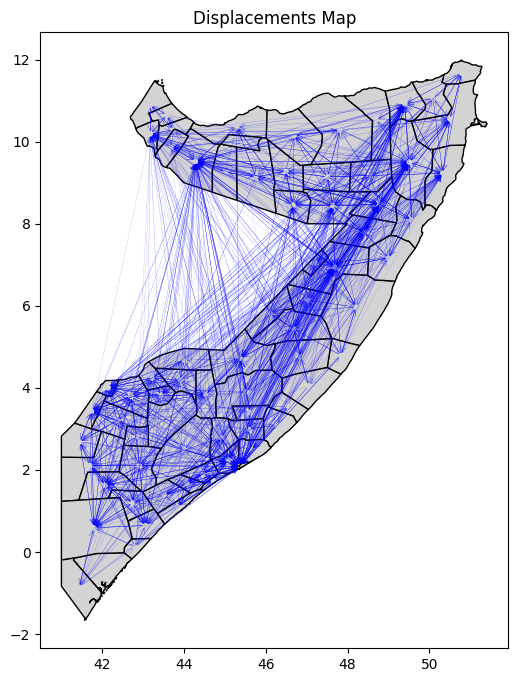

In [10]:
states = states_gdf
annual_flows1.reset_index(inplace=True, drop=True)

# Merge the state boundaries with the flow data
states_flows1 = annual_flows1.merge(states, left_on='Previous (Departure) District', right_on='ADM2_EN')
states_flows = states_flows1.merge(states, left_on='Current (Arrival) District', right_on='ADM2_EN')

# Plotting the map
fig, ax = plt.subplots(figsize=(8, 8))

# Plot the state boundaries
states.plot(ax=ax, color='lightgray', edgecolor='black')

# Plot the arrows with sizes based on the weight column
states_flows.apply(lambda x: ax.annotate("", xy=(x['centroid_y'].x, x['centroid_y'].y), xytext=(x['centroid_x'].x, x['centroid_x'].y),
                                          arrowprops=dict(arrowstyle='->', color='b', lw=np.log(x['Number of Individuals'])/30)), axis=1)
ax.set_title('Displacements Map')
plt.show()

In [ ]:
## merge the risk with the world geodataframe
states_gdf_flow = states_gdf.merge(flow_destination, left_on='ADM2_EN', 
                         right_on='Current (Arrival) District', how='outer')

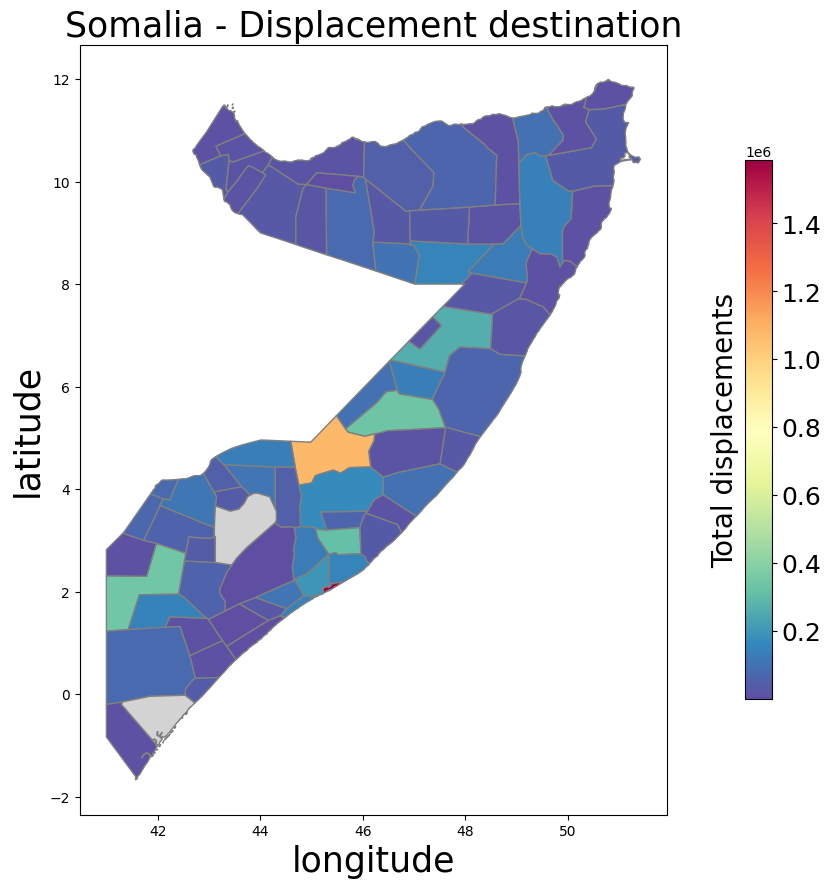

In [ ]:
# color countries according to importation risk

fig, ax = plt.subplots(figsize=(20, 10))
cmap = plt.cm.Spectral_r

# plot countries borders with inner area 
# colored according the value of the 'risk' column
m = states_gdf_flow.plot(ax=ax, 
                column='Number of Individuals',
                edgecolor='grey', 
                legend=False,
                cmap=cmap)
                #norm=norm)

# plot countries with null risk (value NAN) in grey 
states_gdf_flow[states_gdf_flow['Number of Individuals'].isna()].plot(ax=ax, edgecolor='grey', facecolor='lightgrey')

# set colorbar
scatter = m.collections[0]
cbar = plt.colorbar(scatter, ax=ax, shrink=0.7)
cbar.ax.tick_params(labelsize=18)
cbar.ax.yaxis.set_label_position('left')
cbar.set_label(label='Total displacements', size=20)

ax.set_title('Somalia - Displacement destination', fontsize=25)
ax.set_xlabel('longitude', fontsize=25)
ax.set_ylabel('latitude', fontsize=25)
plt.show()

In [ ]:
## merge the risk with the world geodataframe
states_gdf_flow_origin = states_gdf.merge(flow, left_on='ADM2_EN', right_on='Previous (Departure) District', how='outer')

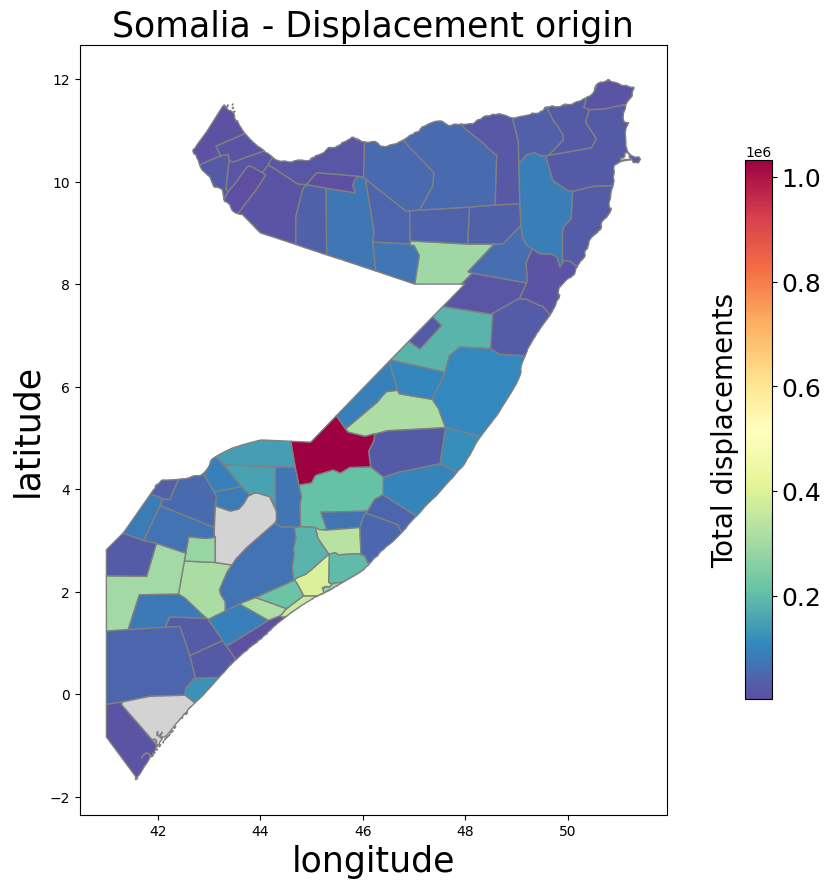

In [ ]:
# color countries according to importation risk

fig, ax = plt.subplots(figsize=(20, 10))
cmap = plt.cm.Spectral_r

# plot countries borders with inner area 
# colored according the value of the 'risk' column
m = states_gdf_flow_origin.plot(ax=ax, 
                column='Number of Individuals',
                edgecolor='grey', 
                legend=False,
                cmap=cmap)

# plot countries with null risk (value NAN) in grey 
states_gdf_flow_origin[states_gdf_flow_origin['Number of Individuals'].isna()].plot(ax=ax, edgecolor='grey', facecolor='lightgrey')

# set colorbar
scatter = m.collections[0]
cbar = plt.colorbar(scatter, ax=ax, shrink=0.7)
cbar.ax.tick_params(labelsize=18)
cbar.ax.yaxis.set_label_position('left')
cbar.set_label(label='Total displacements', size=20)

ax.set_title('Somalia - Displacement origin', fontsize=25)
ax.set_xlabel('longitude', fontsize=25)
ax.set_ylabel('latitude', fontsize=25)
plt.show()